In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import copy


In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors
!unzip -q rockpaperscissors.zip -d rockpaperscissors

Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 97%|███████████████████████████████████████▊ | 297M/306M [00:02<00:00, 150MB/s]
100%|█████████████████████████████████████████| 306M/306M [00:02<00:00, 148MB/s]


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to create directories for train, val, test splits
def prepare_data_dir(original_dir, base_dir, train_size=0.6, val_size=0.2):
    classes = ['rock', 'paper', 'scissors']
    for cls in classes:
        os.makedirs(os.path.join(base_dir, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'val', cls), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'test', cls), exist_ok=True)

        images = os.listdir(os.path.join(original_dir, cls))
        train_and_val, test = train_test_split(images, test_size=1-train_size-val_size, random_state=42)
        train, val = train_test_split(train_and_val, test_size=val_size/(train_size+val_size), random_state=42)

        for name in train:
            shutil.copy(os.path.join(original_dir, cls, name), os.path.join(base_dir, 'train', cls, name))
        for name in val:
            shutil.copy(os.path.join(original_dir, cls, name), os.path.join(base_dir, 'val', cls, name))
        for name in test:
            shutil.copy(os.path.join(original_dir, cls, name), os.path.join(base_dir, 'test', cls, name))



In [ ]:
#Prepare the dataset directories
original_dir = 'rockpaperscissors/rps-cv-images'
base_dir = 'rockpaperscissors_split'
prepare_data_dir(original_dir, base_dir)

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Load data
data_dir = base_dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_acc_history.append(epoch_acc.cpu().numpy())

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [ ]:
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

model_vgg = models.vgg16(pretrained=True)
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg = model_vgg.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)


In [ ]:
model_resnet, resnet_train_acc, resnet_val_acc = train_model(model_resnet, criterion, optimizer_resnet, num_epochs=6)
model_vgg, vgg_train_acc, vgg_val_acc = train_model(model_vgg, criterion, optimizer_vgg, num_epochs=6)


Epoch 0/5
----------
train Loss: 0.1952 Acc: 0.9321
val Loss: 0.0200 Acc: 0.9954
Epoch 1/5
----------
train Loss: 0.1747 Acc: 0.9375
val Loss: 0.0139 Acc: 0.9977
Epoch 2/5
----------
train Loss: 0.1491 Acc: 0.9481
val Loss: 0.0132 Acc: 1.0000
Epoch 3/5
----------
train Loss: 0.1522 Acc: 0.9436
val Loss: 0.0104 Acc: 1.0000
Epoch 4/5
----------
train Loss: 0.1368 Acc: 0.9443
val Loss: 0.0090 Acc: 1.0000
Epoch 5/5
----------
train Loss: 0.1379 Acc: 0.9497
val Loss: 0.0069 Acc: 1.0000
Best val Acc: 1.0000
Epoch 0/5
----------
train Loss: 0.6232 Acc: 0.7178
val Loss: 0.0302 Acc: 0.9909
Epoch 1/5
----------
train Loss: 0.2315 Acc: 0.9130
val Loss: 0.0319 Acc: 0.9886
Epoch 2/5
----------
train Loss: 0.1953 Acc: 0.9237
val Loss: 0.0723 Acc: 0.9749
Epoch 3/5
----------
train Loss: 0.1636 Acc: 0.9382
val Loss: 0.0125 Acc: 0.9954
Epoch 4/5
----------
train Loss: 0.1231 Acc: 0.9512
val Loss: 0.0041 Acc: 0.9977
Epoch 5/5
----------
train Loss: 0.1297 Acc: 0.9519
val Loss: 0.0367 Acc: 0.9863
Best va

In [ ]:
def plot_accuracy_curves(train_acc, val_acc, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    plt.show()

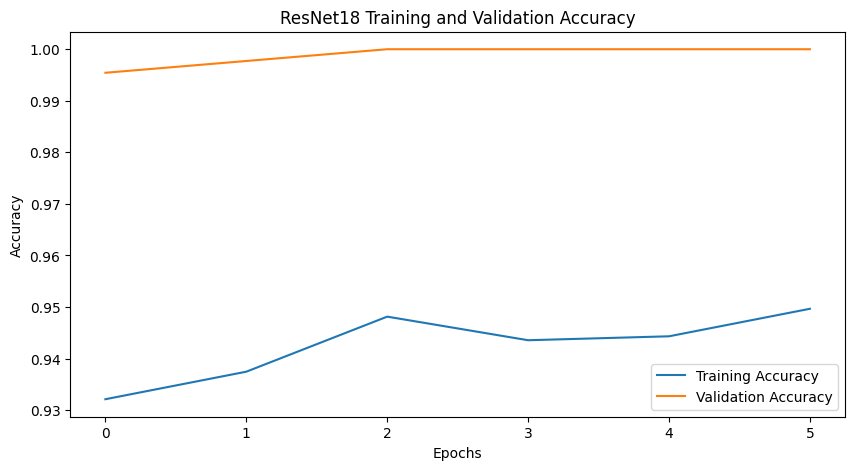

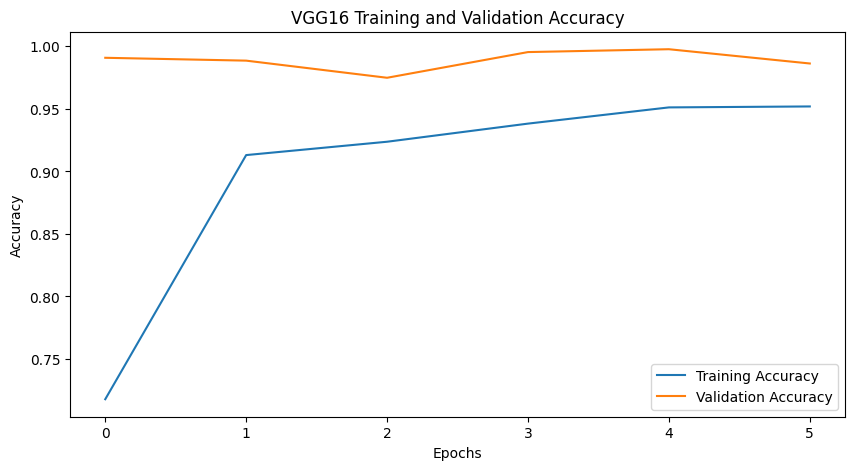

In [ ]:
plot_accuracy_curves(resnet_train_acc, resnet_val_acc, 'ResNet18')
plot_accuracy_curves(vgg_train_acc, vgg_val_acc, 'VGG16')


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

    return all_labels, all_preds

In [ ]:
best_model = model_resnet if max(resnet_val_acc) > max(vgg_val_acc) else model_vgg
all_labels, all_preds = evaluate_model(best_model, dataloaders)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Test Accuracy: 0.9977
Confusion Matrix:
[[143   0   0]
 [  0 146   0]
 [  1   0 149]]

Classification Report:
              precision    recall  f1-score   support

       paper       0.99      1.00      1.00       143
        rock       1.00      1.00      1.00       146
    scissors       1.00      0.99      1.00       150

    accuracy                           1.00       439
   macro avg       1.00      1.00      1.00       439
weighted avg       1.00      1.00      1.00       439

